In [1]:
import pandas as pd
import unicodedata
import re

from tqdm import tqdm
tqdm.pandas(desc="Progress")

In [2]:
import os
path = os.getcwd()
path

'/Users/ryanphung/Projects/Linguistics/chinese-hanviet'

In [3]:
# Step 1: read Chinese words from a frequency list
df_chinese_words = pd.read_csv('inputs/leeds.txt', sep=' ', names=['rank','frequency','word'], skiprows=[0,1,2,3])
df_chinese_words

,rank,frequency,word
0,1,66293.28,，
1,2,45402.97,的
2,3,14216.88,了
3,4,12935.94,我
4,5,11879.45,一
...,...,...,...
49995,49996,0.63,陕西人
49996,49997,0.63,封建制度
49997,49998,0.63,牛郎织女
49998,49999,0.63,着眼点


In [4]:
# add pinyin

import pinyin
print(pinyin.get('你好'))

df_chinese_words['pinyin'] = df_chinese_words.progress_apply(
    lambda x:pinyin.get(str(x['word'])),
    axis=1
)

nǐhǎo


Progress: 100%|██████████| 50000/50000 [00:01<00:00, 30516.63it/s]


In [5]:
# add traditional
import chinese_converter

df_chinese_words['traditional'] = df_chinese_words.progress_apply(
    lambda x:chinese_converter.to_traditional(str(x['word'])),
    axis=1
)

Progress: 100%|██████████| 50000/50000 [00:01<00:00, 48318.75it/s]


In [6]:
# read Thieu Chuu character dictionary

df_chars_thieuchuu = pd.read_csv(
    'inputs/thieuchuu.txt', sep=r'=|\s\[|\]', names=['character', 'hanviet', 'pinyin', 'meaning'],
    engine='python', # so that we can use regex in seperator
    keep_default_na=False, na_values=[''] # this is important to prevent intepreting '难 nan' as NaN (float)
)
df_chars_thieuchuu = df_chars_thieuchuu.drop(columns=['pinyin', 'meaning'])

df_chars_thieuchuu

,character,hanviet
0,一,nhất
1,丁,"đinh, chênh"
2,七,thất
3,万,"vạn, mặc"
4,丈,trượng
...,...,...
10021,龟,"quy, cưu, quân"
10022,龝,thu
10023,龠,"dược, thược"
10024,龡,xúy


In [7]:
# read phienam.txt

df_chars_phienam = pd.read_csv(
    'inputs/phienam.txt', sep=r'=', names=['character', 'hanviet'],
    keep_default_na=False, na_values=[''] # this is important to prevent intepreting '难 nan' as NaN (float)
)
df_chars_phienam

,character,hanviet
0,第,đệ
1,九,cửu
2,章,chương
3,以,dĩ
4,战,chiến
...,...,...
11406,生,sinh
11407,噌,tạch
11408,噼,hoa
11409,哐,bang


In [8]:
# merge the 2 sources of Han Viet sounds

df_chars = pd.concat([df_chars_thieuchuu, df_chars_phienam])
df_chars = df_chars.set_index('character')

# dedup rows by joining them (sometimes a value like 两 appears many times with different values)
df_chars = df_chars.groupby('character').agg({'hanviet': ', '.join})

df_chars

,hanviet
character,
一,"nhất, nhất"
丁,"đinh, chênh, đinh"
七,"thất, thất"
万,"vạn, mặc, vạn, vạn"
丈,"trượng, trượng"
...,...
龝,"thu, thu"
龟,"quy, cưu, quân, quy"
龠,"dược, thược, dược"


In [9]:
# Adding all missing traditional and simplified sounds

def get_traditional_variant(c):
    t = chinese_converter.to_traditional(c)
    return t if t != c else None

def get_simplified_variant(c):
    t = chinese_converter.to_simplified(c)
    return t if t != c else None

df_chars['traditional'] = df_chars.apply(lambda x:get_traditional_variant(x.name), axis=1)
df_chars['simplified'] = df_chars.apply(lambda x:get_simplified_variant(x.name), axis=1)

df_chars_traditional = df_chars[df_chars['traditional'].notnull()].copy()
df_chars_traditional = df_chars_traditional.reset_index()
df_chars_traditional = df_chars_traditional[['traditional', 'hanviet']]
df_chars_traditional = df_chars_traditional.rename(columns={ 'traditional' : 'character' })
df_chars_traditional = df_chars_traditional.set_index('character')

df_chars_simplified = df_chars[df_chars['simplified'].notnull()].copy()
df_chars_simplified = df_chars_simplified.reset_index()
df_chars_simplified = df_chars_simplified[['simplified', 'hanviet']]
df_chars_simplified = df_chars_simplified.rename(columns={ 'simplified' : 'character' })
df_chars_simplified = df_chars_simplified.set_index('character')

df_chars = df_chars.drop(columns=['traditional', 'simplified'])
df_chars = pd.concat([df_chars, df_chars_simplified, df_chars_traditional])
df_chars

,hanviet
character,
一,"nhất, nhất"
丁,"đinh, chênh, đinh"
七,"thất, thất"
万,"vạn, mặc, vạn, vạn"
丈,"trượng, trượng"
...,...
齷,"ác, ác"
龍,"long, sủng, long"
龔,"cung, cung"


In [10]:
# dedup rows by joining them (sometimes a value like 两 appears many times with different values)
df_chars = df_chars.groupby('character').agg({'hanviet': ', '.join})

# dedup each hanviet cell using set
df_chars['hanviet'] = df_chars['hanviet'].apply(lambda x:set(x.split(', ')))

df_chars

,hanviet
character,
㑩,{la}
䇲,"{sách, hiệp, giáp}"
一,{nhất}
丁,"{chênh, đinh}"
七,{thất}
...,...
龝,{thu}
龟,"{cưu, quân, quy}"
龠,"{thược, dược}"


In [11]:
def normalize_vn_word(a):
    r = a.lower()
    r = re.sub(r'((?<=[b-df-hj-np-tv-z])|(?<=qu))(y)', 'i', r)
    r = re.sub(r'((?<=[b-df-hj-np-tv-z])|(?<=qu))(ý)', 'í', r)
    r = re.sub(r'((?<=[b-df-hj-np-tv-z])|(?<=qu))(ỳ)', 'ì', r)
    r = re.sub(r'((?<=[b-df-hj-np-tv-z])|(?<=qu))(ỷ)', 'ỉ', r)
    r = re.sub(r'((?<=[b-df-hj-np-tv-z])|(?<=qu))(ỹ)', 'ĩ', r)
    r = re.sub(r'((?<=[b-df-hj-np-tv-z])|(?<=qu))(ỵ)', 'ị', r)
    
    return r

print(normalize_vn_word('con quỷ thuỷ thủ tự kỷ ỷ lại kỵ mã mỹ thuật hy vọng'))

con quỉ thuỷ thủ tự kỉ ỷ lại kị mã mĩ thuật hi vọng


In [12]:
def compare_vn_words(a, b):
    return normalize_vn_word(a) == normalize_vn_word(b)

print(compare_vn_words('mỹ thuật', 'mĩ thuật'))
print(compare_vn_words('mỹ thuật', 'ma thuật'))
print(compare_vn_words('MỸ THUẬT', 'mĩ thuật'))
print(compare_vn_words('con quỷ thuỷ thủ tự kỷ ỷ lại kỵ mã mỹ thuật hy vọng', 'con quỉ thuỷ thủ tự kỉ ỷ lại kỵ mã mỹ thuật hy vọng'))

True
False
True
True


In [13]:
# Function to get Han Viet sound from Chinese word
def get_hanviet(word):
    result = []
    
    for c in word:
        if not c in df_chars.index:
            return []
        df_of_c = df_chars.loc[c]
        c_hv = list(df_of_c['hanviet'])
        if (len(result) == 0):
            result = c_hv
        else:
            row = result
            result = []
            for i in row:
                for j in c_hv:
                    result.append(' '.join([i, j]))
    
    return result

# Test
print(get_hanviet('利害'))
print(get_hanviet('我们'))
print(get_hanviet('看看'))

# Does not exist
print(get_hanviet('.'))

print(get_hanviet('国际'))
print(get_hanviet('国際')) # Traditional

# Both should get the same list of sounds
print(get_hanviet('怎么办'))
print(get_hanviet('怎麼辦'))

# Should combine output from simplified and traditional
print(get_hanviet('有着'))

# Both should get the same list of sounds
print(get_hanviet('通过'))
print(get_hanviet('通過'))

print(get_hanviet('时间'))

['lợi hạt', 'lợi hại']
['ngã môn']
['khán khán']
[]
['quốc tế']
['quốc tế']
['chẩm yêu biện', 'chẩm yêu bạn', 'chẩm ma biện', 'chẩm ma bạn']
['chẩm yêu biện', 'chẩm yêu bạn', 'chẩm ma biện', 'chẩm ma bạn']
['hữu trứ', 'hữu khán', 'dựu trứ', 'dựu khán']
['thông qua', 'thông quá']
['thông qua', 'thông quá']
['thì gian', 'thời gian']


In [14]:
# Step 2: find all Han Viet sound of these Chinese words

df_chinese_words['hanviet'] = df_chinese_words.progress_apply(lambda x:get_hanviet(str(x['word'])), axis=1)
df_chinese_words

Progress: 100%|██████████| 50000/50000 [00:13<00:00, 3607.13it/s]


,rank,frequency,word,pinyin,traditional,hanviet
0,1,66293.28,，,，,，,[]
1,2,45402.97,的,de,的,"[để, đích]"
2,3,14216.88,了,le,瞭,"[liệu, liễu]"
3,4,12935.94,我,wǒ,我,[ngã]
4,5,11879.45,一,yī,一,[nhất]
...,...,...,...,...,...,...
49995,49996,0.63,陕西人,shǎnxīrén,陝西人,"[thiểm tây nhân, thiểm tê nhân, xiểm tây nhân,..."
49996,49997,0.63,封建制度,fēngjiànzhìdù,封建制度,"[phong kiển chế đạc, phong kiển chế độ, phong ..."
49997,49998,0.63,牛郎织女,níulángzhīnv̌,牛郎織女,"[ngưu lang chức nhữ, ngưu lang chức nứ, ngưu l..."
49998,49999,0.63,着眼点,zháoyǎndiǎn,著眼點,"[trứ nhãn điểm, khán nhãn điểm]"


In [15]:
# Print those words where no sound can be found

df_chinese_no_sound = df_chinese_words[df_chinese_words['hanviet'].apply(lambda x:not x)]

df_chinese_no_sound = df_chinese_no_sound[df_chinese_no_sound['word'].apply(lambda x:not re.match('[a-zA-Z]+', str(x)))] # exclude English words

df_chinese_no_sound.to_csv('intermediate/chinese-no-sound-found.tsv', sep='\t', index_label=['no'])

In [16]:
# df_chinese_words_with_hanviet.to_csv('outputs/chinese-words-with-hanviet.tsv', sep='\t', index_label=['no'])

In [17]:
# Read a Viet Phrases dictionary

df_vietphrases = pd.read_csv(
    'inputs/vietphrases.txt', sep='=', names=['phrase', 'meaning'],
    keep_default_na=False, na_values=[''] # this is important to prevent intepreting '难 nan' as NaN (float)
)

df_vietphrases['meaning'] = df_vietphrases['meaning'].apply(
    lambda x:
        list(filter(lambda x:x, x.split('/'))) # remove empties
        if isinstance(x, str)
        else []
)
df_vietphrases

,phrase,meaning
0,充满希望的跋涉比到达目的地更能给人乐趣,[sung mãn hi vọng đích bạt thiệp bỉ đáo đạt mụ...
1,充滿希望的跋涉比到達目的地更能給人樂趣,[sung mãn hi vọng đích bạt thiệp bỉ đáo đạt mụ...
2,来的时候是这么来的走的时候也就这么走了,"[khi tới như thế nào, khi đi cũng như vậy]"
3,无一事而不学无一时而不学无一处而不得,"[vô nhất sự nhi bất học, vô nhất thì nhi bất h..."
4,無一事而不學無一時而不學無一處而不得,"[vô nhất sự nhi bất học, vô nhất thì nhi bất h..."
...,...,...
107306,鹅,"[nga, ngan, ngỗng]"
107307,麻,"[ma, tê dại]"
107308,黏,[dính]
107309,鼻,[mũi]


In [18]:
# THE MAIN MERGE

df_chinese_words_with_hanviet_and_meaning = df_chinese_words.merge(df_vietphrases, left_on='word', right_on='phrase', how='inner')
df_chinese_words_with_hanviet_and_meaning

,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning
0,2,45402.97,的,de,的,"[để, đích]",的,[đích]
1,3,14216.88,了,le,瞭,"[liệu, liễu]",了,[liễu]
2,4,12935.94,我,wǒ,我,[ngã],我,[ta]
3,5,11879.45,一,yī,一,[nhất],一,"[một, nhất]"
4,6,9854.95,在,zài,在,[tại],在,[ở]
...,...,...,...,...,...,...,...,...
30028,49984,0.63,白肉,báiròu,白肉,"[bạch nhụ, bạch nhục, bạch nậu]",白肉,"[thịt luộc, thịt lợn luộc]"
30029,49985,0.63,成林,chénglín,成林,[thành lâm],成林,[thành rừng]
30030,49989,0.63,交合,jiāohé,交合,"[giao hợp, giao cáp]",交合,"[giao hợp, tính giao, giao cấu]"
30031,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,[noãn hồng hồng],暖烘烘,[ấm áp dễ chịu]


In [19]:
# WHAT ABOUT THOSE WITH NO MEANING FOUND IN THE DICTIONARY?
# Output them to a file

df_chinese_words_with_hanviet_and_meaning_outer = df_chinese_words.merge(df_vietphrases, left_on='word', right_on='phrase', how='outer')

df_chinese_words_with_hanviet_no_meaning_found = \
    df_chinese_words_with_hanviet_and_meaning_outer[df_chinese_words_with_hanviet_and_meaning_outer['meaning'].apply(lambda x:isinstance(x, float))].copy()

df_chinese_words_with_hanviet_no_meaning_found['hanviet'] = \
    df_chinese_words_with_hanviet_no_meaning_found['hanviet'].apply(lambda x:', '.join(x))

df_chinese_words_with_hanviet_no_meaning_found = df_chinese_words_with_hanviet_no_meaning_found.drop(columns=['phrase', 'meaning'])

df_chinese_words_with_hanviet_no_meaning_found.to_csv('intermediate/chinese-no-meaning-found.tsv', sep='\t', index=False)

In [20]:
# Function to find if the Han Viet sounds match a word in the meaning

def match(a=[], b=[]):
    result = []
    for a_part in a:
        for b_part in b:
            if compare_vn_words(a_part, b_part):
                result += [a_part.lower(), b_part.lower()]
    
    return list(set(result))
    
print(match(['thành lâm'], ['thành rừng']))
print(match(['chế độ', 'chế đạc'], ['chế độ']))
print(match(['chế độ'], ['chế độ', 'chế đạc']))
print(match(['kĩ thuật', 'kỹ thuật'], ['kỹ thuật']))
print(match(['kỹ thuật'], ['kĩ thuật', 'kỹ thuật']))
print(match(['bắc kinh'], ['Bắc Kinh']))
print(match(['kĩ thuật'], ['trang bị kĩ thuật', 'trang thiết bị', 'trang bị kỹ thuật', 'kỹ thuật', 'kĩ thuật']))
print(match(['thiết trí'], ['thiết trí', 'xây dựng', 'thiết lập', 'trang bị', 'lắp đặt']))

[]
['chế độ']
['chế độ']
['kỹ thuật', 'kĩ thuật']
['kỹ thuật', 'kĩ thuật']
['bắc kinh']
['kỹ thuật', 'kĩ thuật']
['thiết trí']


In [21]:
df_chinese_words_with_hanviet_and_meaning['matched'] = df_chinese_words_with_hanviet_and_meaning.progress_apply(
    lambda x:match(x['hanviet'], x['meaning']),
    axis=1
)
df_chinese_words_with_hanviet_and_meaning

Progress: 100%|██████████| 30033/30033 [00:05<00:00, 5710.43it/s]


,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning,matched
0,2,45402.97,的,de,的,"[để, đích]",的,[đích],[đích]
1,3,14216.88,了,le,瞭,"[liệu, liễu]",了,[liễu],[liễu]
2,4,12935.94,我,wǒ,我,[ngã],我,[ta],[]
3,5,11879.45,一,yī,一,[nhất],一,"[một, nhất]",[nhất]
4,6,9854.95,在,zài,在,[tại],在,[ở],[]
...,...,...,...,...,...,...,...,...,...
30028,49984,0.63,白肉,báiròu,白肉,"[bạch nhụ, bạch nhục, bạch nậu]",白肉,"[thịt luộc, thịt lợn luộc]",[]
30029,49985,0.63,成林,chénglín,成林,[thành lâm],成林,[thành rừng],[]
30030,49989,0.63,交合,jiāohé,交合,"[giao hợp, giao cáp]",交合,"[giao hợp, tính giao, giao cấu]",[giao hợp]
30031,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,[noãn hồng hồng],暖烘烘,[ấm áp dễ chịu],[]


In [22]:
df_multisyllabic = df_chinese_words_with_hanviet_and_meaning.drop(
    df_chinese_words_with_hanviet_and_meaning[df_chinese_words_with_hanviet_and_meaning['word'].str.len() == 1].index
)
df_multisyllabic['chinese_rank'] = df_multisyllabic.reset_index().index
df_multisyllabic

,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning,matched,chinese_rank
20,25,2837.94,我们,wǒmen,我們,[ngã môn],我们,"[chúng ta, chúng tôi, chúng tao, chúng tớ]",[],0
26,32,2157.07,没有,méiyǒu,沒有,"[một hữu, một dựu]",没有,"[không có, không, không bằng, không đủ, không ...",[],1
34,42,1921.32,自己,zìjǐ,自己,[tự kỷ],自己,"[chính mình, chính, tự mình, bản thân, mình, nhà]",[],2
39,48,1674.90,他们,tāmen,他們,[tha môn],他们,"[bọn họ, chúng nó, họ]",[],3
49,60,1512.01,什么,shíyāo,什麼,"[thập yêu, thập ma]",什么,"[cái gì, gì, nào, gì đó, nhậm chỉ, mọi thứ, nấ...",[],4
...,...,...,...,...,...,...,...,...,...,...
30028,49984,0.63,白肉,báiròu,白肉,"[bạch nhụ, bạch nhục, bạch nậu]",白肉,"[thịt luộc, thịt lợn luộc]",[],28952
30029,49985,0.63,成林,chénglín,成林,[thành lâm],成林,[thành rừng],[],28953
30030,49989,0.63,交合,jiāohé,交合,"[giao hợp, giao cáp]",交合,"[giao hợp, tính giao, giao cấu]",[giao hợp],28954
30031,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,[noãn hồng hồng],暖烘烘,[ấm áp dễ chịu],[],28955


In [23]:
# Clean up against Opensubs frequency list

df_freq = pd.read_csv('inputs/opensubs-freq.txt', sep='\t', names=['hanviet', 'frequency'])
# drop low frequency words
df_freq = df_freq.drop(df_freq[df_freq['frequency'] == 1].index)
df_freq = df_freq.drop(columns=['frequency'])
df_freq.set_index('hanviet')

""
hanviet
tôi
không
là
anh
có
...
gust
có ý niệm
quỷ xanh


In [24]:
def keep_frequently_used_words(words):
    return list(filter(lambda x:x in df_freq['hanviet'].values, words))

keep_frequently_used_words(['tề tụ', 'tề tựu'])

df_multisyllabic['matched_cleaned'] = df_multisyllabic['matched'].progress_apply(lambda x:keep_frequently_used_words(x))
df_multisyllabic

Progress: 100%|██████████| 28957/28957 [00:15<00:00, 1842.90it/s]


,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning,matched,chinese_rank,matched_cleaned
20,25,2837.94,我们,wǒmen,我們,[ngã môn],我们,"[chúng ta, chúng tôi, chúng tao, chúng tớ]",[],0,[]
26,32,2157.07,没有,méiyǒu,沒有,"[một hữu, một dựu]",没有,"[không có, không, không bằng, không đủ, không ...",[],1,[]
34,42,1921.32,自己,zìjǐ,自己,[tự kỷ],自己,"[chính mình, chính, tự mình, bản thân, mình, nhà]",[],2,[]
39,48,1674.90,他们,tāmen,他們,[tha môn],他们,"[bọn họ, chúng nó, họ]",[],3,[]
49,60,1512.01,什么,shíyāo,什麼,"[thập yêu, thập ma]",什么,"[cái gì, gì, nào, gì đó, nhậm chỉ, mọi thứ, nấ...",[],4,[]
...,...,...,...,...,...,...,...,...,...,...,...
30028,49984,0.63,白肉,báiròu,白肉,"[bạch nhụ, bạch nhục, bạch nậu]",白肉,"[thịt luộc, thịt lợn luộc]",[],28952,[]
30029,49985,0.63,成林,chénglín,成林,[thành lâm],成林,[thành rừng],[],28953,[]
30030,49989,0.63,交合,jiāohé,交合,"[giao hợp, giao cáp]",交合,"[giao hợp, tính giao, giao cấu]",[giao hợp],28954,[giao hợp]
30031,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,[noãn hồng hồng],暖烘烘,[ấm áp dễ chịu],[],28955,[]


In [25]:
df_multisyllabic['hanviet'] = df_multisyllabic['hanviet'].apply(lambda x:'/'.join(x))
df_multisyllabic['meaning'] = df_multisyllabic['meaning'].apply(lambda x:'/'.join(x))
df_multisyllabic['matched'] = df_multisyllabic['matched'].apply(lambda x:'/'.join(x))
df_multisyllabic['matched_cleaned'] = df_multisyllabic['matched_cleaned'].apply(lambda x:'/'.join(x))
df_multisyllabic

,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning,matched,chinese_rank,matched_cleaned
20,25,2837.94,我们,wǒmen,我們,ngã môn,我们,chúng ta/chúng tôi/chúng tao/chúng tớ,,0,
26,32,2157.07,没有,méiyǒu,沒有,một hữu/một dựu,没有,không có/không/không bằng/không đủ/không tới/k...,,1,
34,42,1921.32,自己,zìjǐ,自己,tự kỷ,自己,chính mình/chính/tự mình/bản thân/mình/nhà,,2,
39,48,1674.90,他们,tāmen,他們,tha môn,他们,bọn họ/chúng nó/họ,,3,
49,60,1512.01,什么,shíyāo,什麼,thập yêu/thập ma,什么,cái gì/gì/nào/gì đó/nhậm chỉ/mọi thứ/nấy/cái q...,,4,
...,...,...,...,...,...,...,...,...,...,...,...
30028,49984,0.63,白肉,báiròu,白肉,bạch nhụ/bạch nhục/bạch nậu,白肉,thịt luộc/thịt lợn luộc,,28952,
30029,49985,0.63,成林,chénglín,成林,thành lâm,成林,thành rừng,,28953,
30030,49989,0.63,交合,jiāohé,交合,giao hợp/giao cáp,交合,giao hợp/tính giao/giao cấu,giao hợp,28954,giao hợp
30031,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,noãn hồng hồng,暖烘烘,ấm áp dễ chịu,,28955,


In [26]:
df_matched = df_multisyllabic.drop(
    df_multisyllabic[df_multisyllabic['matched_cleaned'].apply(lambda x:not x)].index
)
df_matched['index'] = df_matched.reset_index().index + 1
df_matched

,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning,matched,chinese_rank,matched_cleaned,index
57,68,1332.15,可以,kěyǐ,可以,khả dĩ/khắc dĩ,可以,có thể/khả dĩ/có khả năng/có năng lực/cho phép...,khả dĩ,5,khả dĩ,1
66,81,1106.78,中国,zhōngguó,中國,trung quốc/trúng quốc,中国,Trung Quốc/Trung Hoa Trung Quốc/China/nước cộn...,trung quốc,8,trung quốc,2
81,97,916.48,现在,xiànzài,現在,hiện tại,现在,hiện tại/hiện nay/bây giờ,hiện tại,13,hiện tại,3
88,105,831.20,时间,shíjiān,時間,thì gian/thời gian,时间,thời gian/giờ/khoảng thời gian/thời điểm,thời gian,16,thời gian,4
96,113,775.81,问题,wèntí,問題,vấn đề,问题,vấn đề/câu hỏi/đề hỏi/quan trọng/mấu chốt/chuy...,vấn đề,18,vấn đề,5
...,...,...,...,...,...,...,...,...,...,...,...,...
29975,49833,0.63,先王,xiānwáng,先王,tiên vượng/tiên vương/tiến vượng/tiến vương,先王,tiên vương/tiên đế,tiên vương,28899,tiên vương,4554
29982,49847,0.63,精气,jīngqì,精氣,tinh khí/tinh khất,精气,tinh khí,tinh khí,28906,tinh khí,4555
29988,49858,0.63,家奴,jiānú,家奴,cô nô/gia nô,家奴,gia nô/đầy tớ/tôi tớ,gia nô,28912,gia nô,4556
30002,49890,0.63,安神,ānshén,安神,an thần,安神,an thần/làm yên tâm,an thần,28926,an thần,4557


In [27]:
df_matched.to_csv(
    'outputs/chinese-hanviet-cognates.tsv', sep='\t', index=False,
    columns=['chinese_rank', 'frequency', 'word', 'traditional', 'pinyin', 'matched_cleaned', 'meaning'],
    header=['chinese word ranking', 'frequency', 'word', 'traditional', 'pinyin', 'hanviet', 'meaning']
)

In [28]:
df_not_matched = df_multisyllabic.drop(
    df_multisyllabic[df_multisyllabic['matched_cleaned'].apply(lambda x:bool(x))].index
)
df_not_matched['index'] = df_not_matched.reset_index().index + 1
df_not_matched

,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning,matched,chinese_rank,matched_cleaned,index
20,25,2837.94,我们,wǒmen,我們,ngã môn,我们,chúng ta/chúng tôi/chúng tao/chúng tớ,,0,,1
26,32,2157.07,没有,méiyǒu,沒有,một hữu/một dựu,没有,không có/không/không bằng/không đủ/không tới/k...,,1,,2
34,42,1921.32,自己,zìjǐ,自己,tự kỷ,自己,chính mình/chính/tự mình/bản thân/mình/nhà,,2,,3
39,48,1674.90,他们,tāmen,他們,tha môn,他们,bọn họ/chúng nó/họ,,3,,4
49,60,1512.01,什么,shíyāo,什麼,thập yêu/thập ma,什么,cái gì/gì/nào/gì đó/nhậm chỉ/mọi thứ/nấy/cái q...,,4,,5
...,...,...,...,...,...,...,...,...,...,...,...,...
30027,49983,0.63,进香,jìnxiāng,進香,tiến hương,进香,dâng hương/thắp hương/hành hương,,28951,,24395
30028,49984,0.63,白肉,báiròu,白肉,bạch nhụ/bạch nhục/bạch nậu,白肉,thịt luộc/thịt lợn luộc,,28952,,24396
30029,49985,0.63,成林,chénglín,成林,thành lâm,成林,thành rừng,,28953,,24397
30031,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,noãn hồng hồng,暖烘烘,ấm áp dễ chịu,,28955,,24398


In [29]:
df_not_matched.to_csv(
    'outputs/chinese-hanviet-non-cognates.tsv', sep='\t', index=False,
    columns=['chinese_rank', 'frequency', 'word', 'traditional', 'pinyin', 'hanviet', 'meaning'],
    header=['chinese word ranking', 'frequency', 'word', 'traditional', 'pinyin', 'hanviet', 'meaning']
)

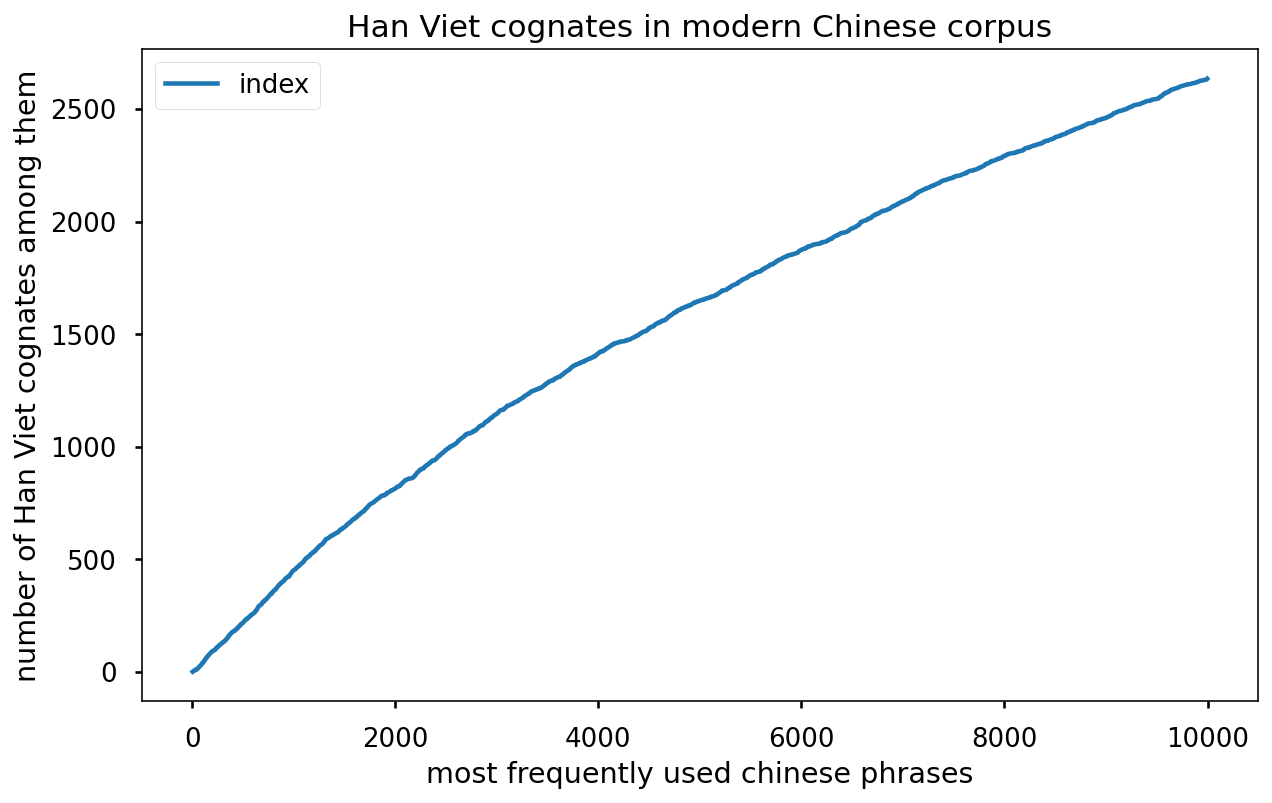

In [30]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.style as style
style.use('seaborn-talk')

ax = df_matched[df_matched['chinese_rank'] < 10000].plot(
    x="chinese_rank", y="index",
    title="Han Viet cognates in modern Chinese corpus",
    xlabel="most frequently used chinese phrases",
    ylabel="number of Han Viet cognates among them",
    figsize=(10,6)
)

In [31]:
fig = ax.get_figure()
fig.savefig('outputs/chart.jpg')

In [32]:
# Print out all personal names (for manual vetting)

prog = re.compile('(^|.*\/)([A-Z].+)')
print(prog.match('Anh'))
print(prog.match('anh'))
print(prog.match('anh/Anh'))

# prog = re.compile('[A-Z].*')
df_matched['cap'] = df_matched.progress_apply(lambda x:prog.match(x['meaning']), axis=1)

df_cap = df_matched[df_matched['cap'].notnull()]

df_cap.to_csv('intermediate/personal-names.tsv', sep='\t', index=False, columns=['index', 'chinese_rank', 'frequency', 'word', 'traditional', 'pinyin', 'matched', 'meaning'])

<re.Match object; span=(0, 3), match='Anh'>
None
<re.Match object; span=(0, 7), match='anh/Anh'>


Progress: 100%|██████████| 4558/4558 [00:00<00:00, 48178.80it/s]
